In [1]:
%load_ext watermark


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp

from pylib._seed_global_rngs import seed_global_rngs


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-05-02T17:36:36.725295+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1027-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

numpy  : 2.1.2
pandas : 2.2.3
seaborn: 0.13.2
teeplot: 1.4.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2025-04-30-profile-mut-screen"
teeplot_subdir


'2025-04-30-profile-mut-screen'

In [5]:
seed_global_rngs(1)


## Get Data


In [6]:
df = pd.read_parquet("https://osf.io/8pgy5/download")


In [7]:
df["replicate_uuid"].nunique()


6

In [8]:
df["is_focal_mutation"] = df["mut_char_pos"] == 0


In [9]:
records = []
for (trt_name, replicate_uuid, screen_uuid, screen_name, tb_stat), grp in df[
    (df["trt_hsurf_bits"] == 0)
    & (df["trt_n_downsample"] == df["trt_n_downsample"].max())
    & (df["tb_stat"].str.contains("ratio"))
].groupby(
    ["trt_name", "replicate_uuid", "screen_uuid", "screen_name", "tb_stat"],
    observed=True,
):
    grp_focal = grp[grp["is_focal_mutation"]]
    grp_nonfocal = grp[~grp["is_focal_mutation"]]

    record = {
        "trt_name": trt_name,
        "replicate_uuid": replicate_uuid,
        "screen_uuid": screen_uuid,
        "screen_name": screen_name,
        "tb_stat": tb_stat,
    }

    records.append(
        {
            **record,
            "binom_p": (
                np.nan if len(grp_focal) == 0 else grp_focal["binom_p"].item()
            ),
            "mutation": "focal",
        },
    )
    records.append(
        {
            **record,
            "binom_p": grp_nonfocal["binom_p"].sample(1).item(),
            "mutation": "nonfocal",
        },
    )


teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=binom-p+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=binom-p+ext=.png


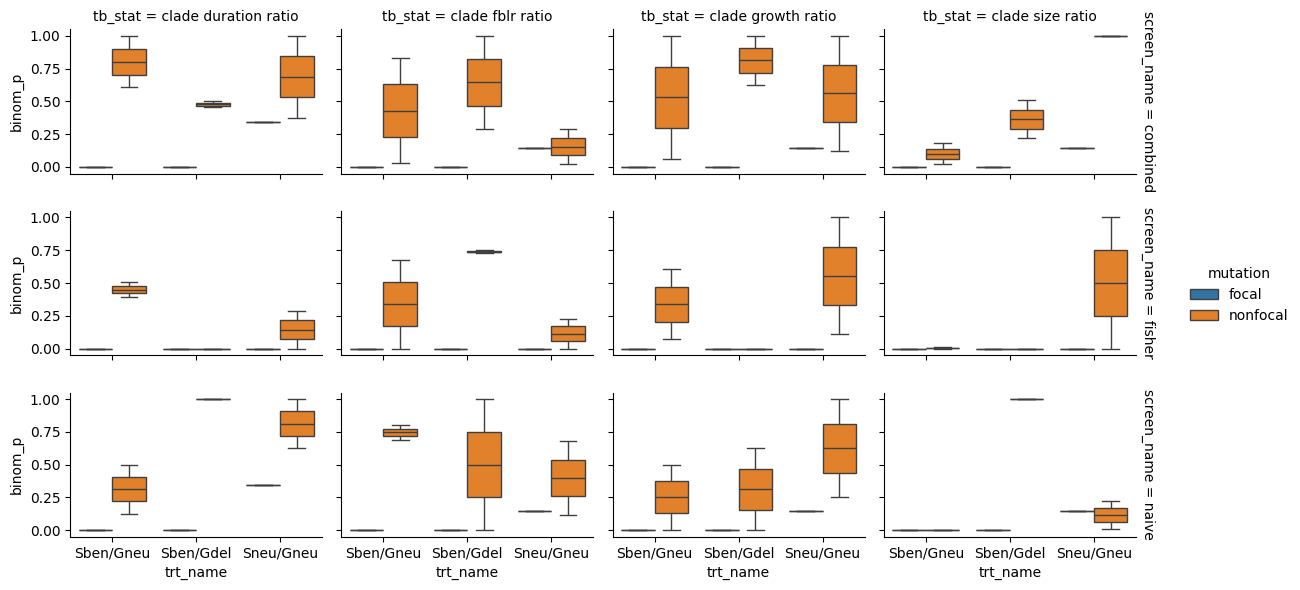

In [10]:
with tp.teed(
    sns.catplot,
    data=pd.DataFrame(records),
    x="trt_name",
    y="binom_p",
    hue="mutation",
    row="screen_name",
    col="tb_stat",
    kind="box",
    height=2,
    aspect=1.5,
    margin_titles=True,
):
    pass
